In [179]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [180]:
feature_class = pd.read_csv('feature_class.csv')
train_df, test_df = train_test_split(feature_class, test_size=0.2, random_state=42) 

In [181]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 25)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(25, 50)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(50, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.softmax(out)
        return out


In [182]:
input_size = 15  
num_classes = 6  

model = SimpleNN(input_size, num_classes)
loss = nn.CrossEntropyLoss()
optimize = optim.Adam(model.parameters(), lr=0.001)

In [183]:
feature_torch = torch.tensor(train_df.drop('label',axis = 1).values, dtype=torch.float32)
label_torch = torch.tensor(train_df['label'].values,dtype=torch.int64)

feature_torch_test = torch.tensor(test_df.drop('label',axis = 1).values, dtype=torch.float32)
label_torch_test = torch.tensor(test_df['label'].values,dtype=torch.int64)


In [184]:
train_dataset = TensorDataset(feature_torch, label_torch)
test_dataset = TensorDataset(feature_torch_test, label_torch_test)

In [185]:
batch_size = 12

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [186]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [187]:
y_pred = []
y_test = []
def validate(last = False):

    model.eval()
    correct = 0
    total = 0
    for features, labels in test_loader: 
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)

        if last:
            y_pred.append(predicted.cpu().numpy())
            y_test.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [188]:
# train the model

epochs = 300
running_loss = 0

# store the loss and accuracy
training_loss_list = []
valid_acc_list = []

for epoch in range(epochs):
    for i, (features, labels) in enumerate(train_loader):

        features, labels = features.to(device), labels.to(device)

        optimize.zero_grad()
        outputs = model.forward(features)
        loss_value = loss(outputs, labels)
        loss_value.backward()
        optimize.step()
        running_loss += loss_value.item()
        labels_correct = torch.argmax(outputs, dim=1) == labels

    if_last = True if epoch == (epochs-1) else False 
    valid_acc = validate(if_last)
    print(f'Epoch: {epoch+1}/{epochs}..',
        f'Training Loss: {running_loss/len(test_loader):.3f}',
        f'Training Accuracy: {100*len(labels_correct)/len(labels):.3f}%',
        f'Validation Accuracy: {valid_acc:.3f}%')
    
    training_loss_list.append(running_loss/len(test_loader))
    valid_acc_list.append(valid_acc)
    
    running_loss = 0.0

Epoch: 1/300.. Training Loss: 7.334 Training Accuracy: 100.000% Validation Accuracy: 24.378%
Epoch: 2/300.. Training Loss: 6.169 Training Accuracy: 100.000% Validation Accuracy: 56.219%
Epoch: 3/300.. Training Loss: 5.691 Training Accuracy: 100.000% Validation Accuracy: 60.945%
Epoch: 4/300.. Training Loss: 5.509 Training Accuracy: 100.000% Validation Accuracy: 65.672%
Epoch: 5/300.. Training Loss: 5.354 Training Accuracy: 100.000% Validation Accuracy: 66.169%
Epoch: 6/300.. Training Loss: 5.319 Training Accuracy: 100.000% Validation Accuracy: 66.418%
Epoch: 7/300.. Training Loss: 5.296 Training Accuracy: 100.000% Validation Accuracy: 66.915%
Epoch: 8/300.. Training Loss: 5.287 Training Accuracy: 100.000% Validation Accuracy: 67.164%
Epoch: 9/300.. Training Loss: 5.286 Training Accuracy: 100.000% Validation Accuracy: 66.915%
Epoch: 10/300.. Training Loss: 5.268 Training Accuracy: 100.000% Validation Accuracy: 67.413%
Epoch: 11/300.. Training Loss: 5.253 Training Accuracy: 100.000% Vali

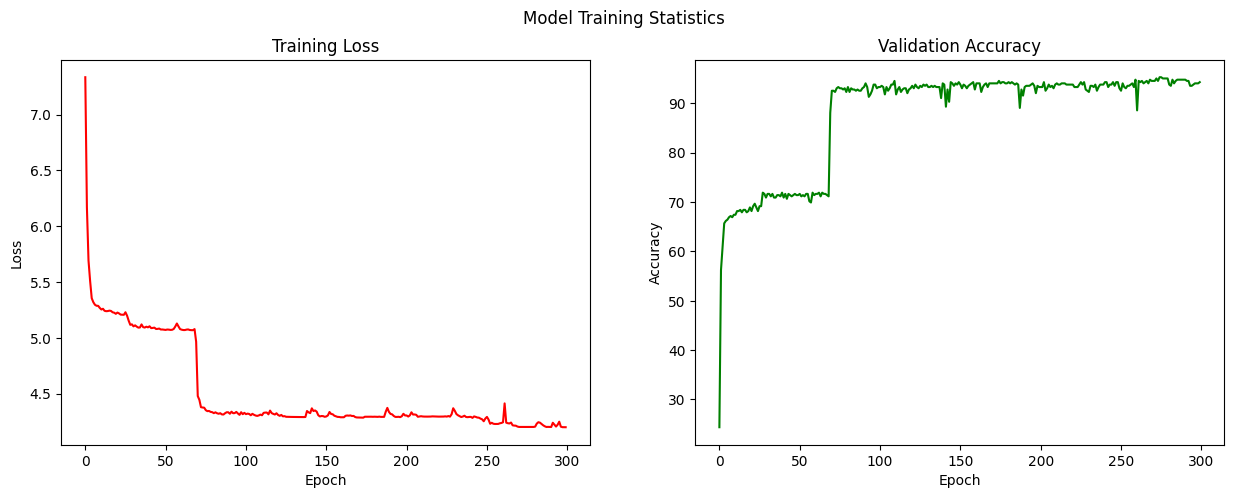

In [189]:
# plot the training loss and validation accuracy in seperate plots next to each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(training_loss_list, color='red')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(valid_acc_list, color='green')
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')

plt.suptitle('Model Training Statistics')
plt.show()

In [190]:
y_pred = list(np.concatenate(y_pred))
confusion = confusion_matrix(y_test,y_pred)
confusion

array([[ 66,   1,   1,   0,   2,   3],
       [  0, 122,   1,   0,   0,   2],
       [  0,   2,  91,   0,   0,   0],
       [  1,   0,   0,  36,   4,   0],
       [  0,   2,   0,   0,  30,   1],
       [  0,   2,   1,   0,   0,  34]])

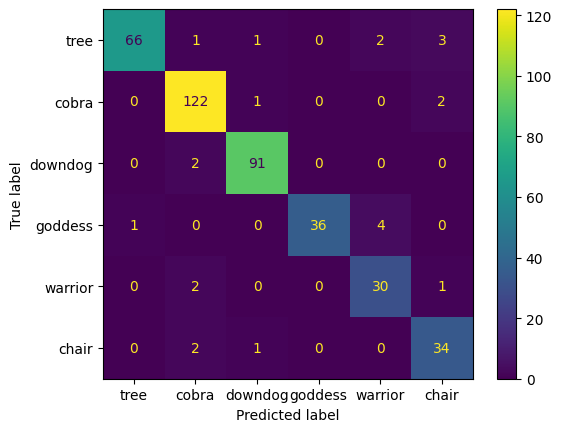

In [191]:
disp = ConfusionMatrixDisplay(confusion, display_labels = ['tree','cobra','downdog','goddess','warrior','chair'])
disp.plot()

In [192]:

target_names = ['tree','cobra','downdog_data','goddess','warrior','chair']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   tree_data       0.99      0.90      0.94        73
  cobra_data       0.95      0.98      0.96       125
downdog_data       0.97      0.98      0.97        93
goddess_data       1.00      0.88      0.94        41
warrior_data       0.83      0.91      0.87        33
  chair_data       0.85      0.92      0.88        37

    accuracy                           0.94       402
   macro avg       0.93      0.93      0.93       402
weighted avg       0.95      0.94      0.94       402

